In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import random
import os
import gc
%matplotlib inline

In [3]:
!ls data

building-image-classification-solutions-keras-transfer-learning
dog_vs_cat
Meta
Meta.csv
pred.csv
Test
Test.csv
traffic_sign_module2.ipynb
Train
Train.csv


In [103]:
train_dir = 'data/dog_vs_cat/dataset/train'
val_dir = 'data/dog_vs_cat/dataset/valid'

train_dogs_dir = f'{train_dir}/dogs'
train_cats_dir = f'{train_dir}/cats'

val_dogs_dir = f'{val_dir}/dogs'
val_cats_dir = f'{val_dir}/cats'

dog_train_files = [files for r, d, files in os.walk(train_dogs_dir)][0]
cat_train_files = [files for r, d, files in os.walk(train_cats_dir)][0]

dog_val_files = [files for r, d, files in os.walk(val_dogs_dir)][0]
cat_val_files = [files for r, d, files in os.walk(val_cats_dir)][0]


d_train_files = [f'{train_dogs_dir}/{file}' for file in dog_train_files]
c_train_files = [f'{train_cats_dir}/{file}' for file in cat_train_files]

d_val_files = [f'{train_dogs_dir}/{file}' for file in dog_val_files]
c_val_files = [f'{train_cats_dir}/{file}' for file in cat_val_files]

train_imgs = d_train_files + c_train_files
random.shuffle(train_imgs)

val_imgs = d_val_files + c_val_files
random.shuffle(train_imgs)

train_imgs[:4]

['data/dog_vs_cat/dataset/train/dogs/dog.3989.jpg',
 'data/dog_vs_cat/dataset/train/cats/cat.3517.jpg',
 'data/dog_vs_cat/dataset/train/cats/cat.3259.jpg',
 'data/dog_vs_cat/dataset/train/dogs/dog.3733.jpg']

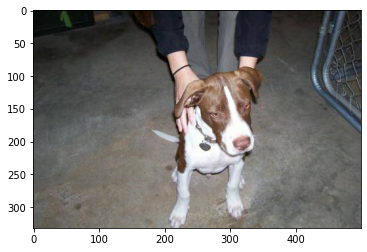

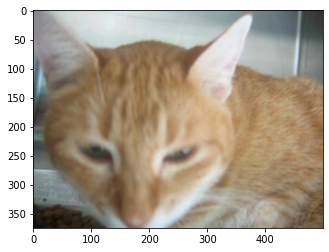

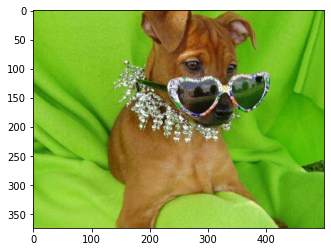

In [58]:
import matplotlib.image as mpimg
for ima in train_imgs[0:3]:
    img = mpimg.imread(ima)
    implot = plt.imshow(img)
    plt.show()

In [108]:
nrows = 150
ncolumns = 150
channels = 3

batch_size = 32

def read_and_process_image(list_of_images):
    X = []
    y = []
    
    for image in list_of_images:
#         print(image)
        if 'DS_Store' not in image:
            X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows, ncolumns), interpolation=cv2.INTER_CUBIC))
            if 'dogs' in image:
                y.append(1)
            elif 'cats' in image:
                y.append(0)
    return X, y

In [93]:
X, y = read_and_process_image(train_imgs)

<ipython-input-94-7fbb67e8d401>:4: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(5 / columns +1, columns, i +1)


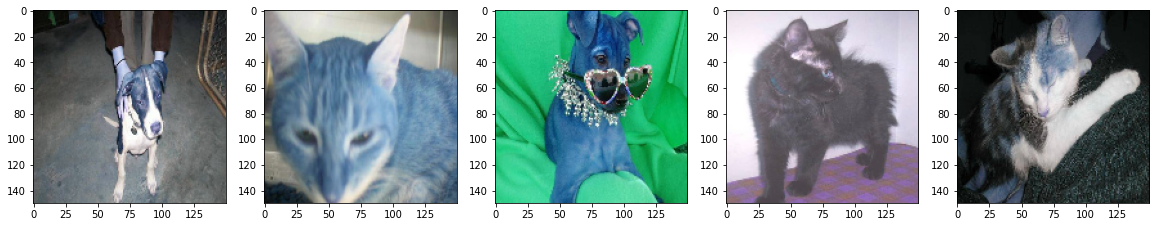

In [94]:
plt.figure(figsize=(20, 10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns +1, columns, i +1)
    plt.imshow(X[i])

Shape of train images is : (1998, 150, 150, 3)
Shape of labels is: (1998,)


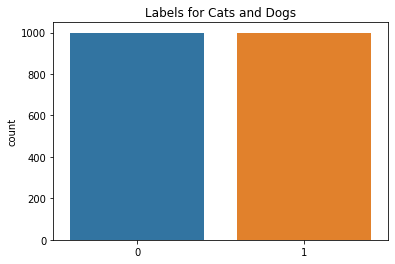

In [95]:
import seaborn as sns

X = np.array(X)
y = np.array(y)
sns.countplot(y)
plt.title('Labels for Cats and Dogs')
print(f'Shape of train images is : {X.shape}')
print(f'Shape of labels is: {y.shape}')

In [96]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2)

In [99]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

In [101]:
# create the model
# Using VGGnet
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(2, 2))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [116]:
# compile our model
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['accuracy'])

In [117]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validate_datagen = ImageDataGenerator(rescale=1./255)

In [118]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = validate_datagen.flow(X_val, y_val, batch_size=batch_size)

In [ ]:
history = model.fit_generator(train_generator, steps_per_epoch=len(X_train)//batch_size, epochs=64, validation_data=val_generator, validation_steps=len(X_val)//batch_size)

Epoch 1/64
49/49 [==============================] - 25s 504ms/step - loss: 0.6951 - accuracy: 0.5013 - val_loss: 0.6847 - val_accuracy: 0.5990
Epoch 2/64
49/49 [==============================] - 28s 578ms/step - loss: 0.6925 - accuracy: 0.5083 - val_loss: 0.6760 - val_accuracy: 0.5573
Epoch 3/64
49/49 [==============================] - 30s 606ms/step - loss: 0.6862 - accuracy: 0.5453 - val_loss: 0.6633 - val_accuracy: 0.6510
Epoch 4/64
49/49 [==============================] - 31s 629ms/step - loss: 0.6822 - accuracy: 0.5587 - val_loss: 0.6516 - val_accuracy: 0.6172
Epoch 5/64
49/49 [==============================] - 31s 638ms/step - loss: 0.6714 - accuracy: 0.5856 - val_loss: 0.6397 - val_accuracy: 0.6615
Epoch 6/64
49/49 [==============================] - 32s 649ms/step - loss: 0.6620 - accuracy: 0.5907 - val_loss: 0.6592 - val_accuracy: 0.5729
Epoch 7/64
49/49 [==============================] - 32s 662ms/step - loss: 0.6561 - accuracy: 0.5945 - val_loss: 0.6318 - val_accuracy: 0.6328